# Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications import inception_v3
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing for DenseNet121

## Data Preprocessing

In [ ]:
data_dir = '/content/drive/MyDrive/Data/The IQ-OTHNCCD lung cancer dataset'
categories = ['begin', 'malignants', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Convert to rgb image
    img = img / 255.0  # Normalize pixels in the range [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)


print('Data length:', len(data))
print('labels counts:', Counter(labels))

X = np.array(data).reshape(-1, 224, 224, 3)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


## Split Data

In [ ]:
X_fold, X_valid, y_fold, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
# X,y valid are used for evaluate matrix

print('Train length:', len(X_fold), X_fold.shape)
print('Valid length:', len(X_valid), X_valid.shape)

Train length: 877 (877, 224, 224, 3)
Valid length: 220 (220, 224, 224, 3)


## Data Visualization

**NORMAL CASE**

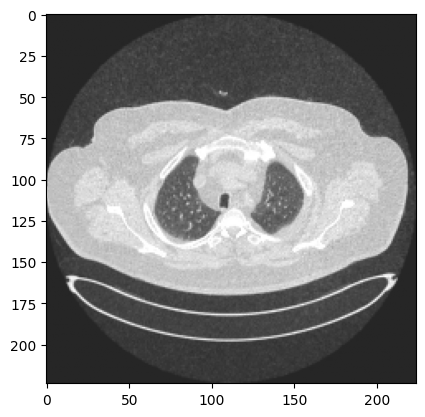

In [ ]:
plt.imshow(X[y==2][3])

**MAGLIGNANT CASE**

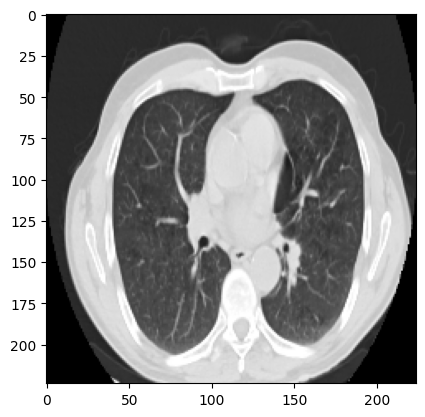

In [ ]:
plt.imshow(X[y==1][0])

**BENGIN CASE**

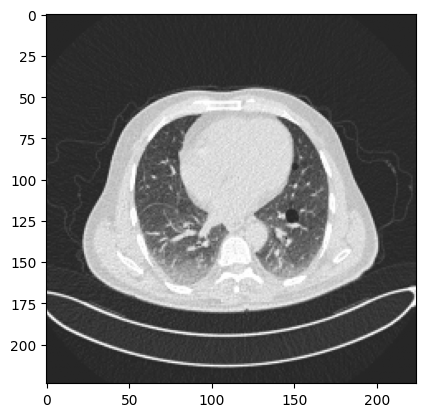

In [ ]:
plt.imshow(X[y==0][0])

# DenseNet121

## Build Model

In [ ]:
# Load pre-trained DenseNet121 model
DenseNetModel = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in DenseNetModel.layers:
    layer.trainable = False

# Add custom classification head
x = DenseNetModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model_denseNet = Model(inputs=DenseNetModel.input, outputs=output)

# model_denseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the modified model
model_denseNet.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

## Compile model

In [ ]:
model_denseNet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Traning model

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_denseNet = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    history_denseNet = model_denseNet.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])
    model_accuracy.extend(history_denseNet.history['accuracy'])
    valid_accuracy.extend(history_denseNet.history['val_accuracy'])
    model_loss.extend(history_denseNet.history['loss'])
    valid_loss.extend(history_denseNet.history['val_loss'])


Epoch 1/20
55/55 [==============================] - 27s 187ms/step - loss: 0.5799 - accuracy: 0.7662 - val_loss: 0.2723 - val_accuracy: 0.9375
Epoch 2/20
55/55 [==============================] - 4s 65ms/step - loss: 0.3016 - accuracy: 0.8974 - val_loss: 0.1740 - val_accuracy: 0.9432
Epoch 3/20
55/55 [==============================] - 4s 65ms/step - loss: 0.2307 - accuracy: 0.9156 - val_loss: 0.1332 - val_accuracy: 0.9545
Epoch 4/20
55/55 [==============================] - 4s 72ms/step - loss: 0.1900 - accuracy: 0.9282 - val_loss: 0.1488 - val_accuracy: 0.9659
Epoch 5/20
55/55 [==============================] - 4s 72ms/step - loss: 0.1549 - accuracy: 0.9441 - val_loss: 0.0844 - val_accuracy: 0.9773
Epoch 6/20
55/55 [==============================] - 4s 65ms/step - loss: 0.1592 - accuracy: 0.9418 - val_loss: 0.0973 - val_accuracy: 0.9886
Epoch 7/20
55/55 [==============================] - 4s 72ms/step - loss: 0.1696 - accuracy: 0.9373 - val_loss: 0.0930 - val_accuracy: 0.9830
Epoch 8/20


## Model Evaluation

In [ ]:
y_pred2 = model_denseNet.predict(X_valid, verbose=1)
y_pred_bool2 = np.argmax(y_pred2, axis=1)

print(classification_report(y_valid, y_pred_bool2))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool2))

7/7 [==============================] - 11s 709ms/step
              precision    recall  f1-score   support

           0       0.96      0.77      0.85        30
           1       0.99      0.98      0.99       117
           2       0.90      0.99      0.94        73

    accuracy                           0.95       220
   macro avg       0.95      0.91      0.93       220
weighted avg       0.96      0.95      0.95       220

[[ 23   1   6]
 [  0 115   2]
 [  1   0  72]]


## Model Visualization

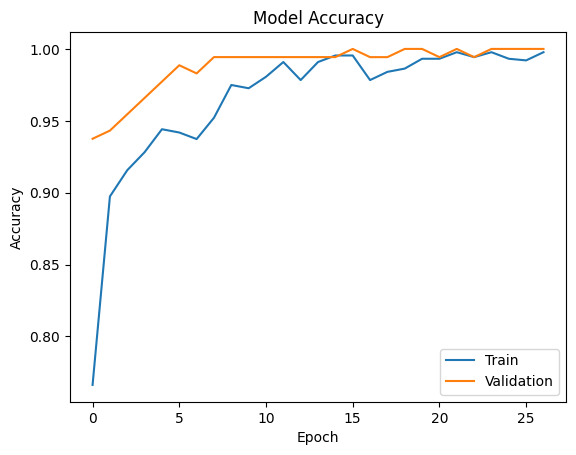

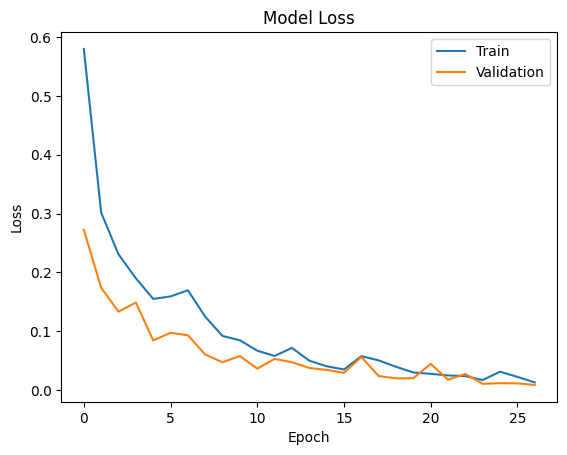

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()